In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import time
import glob
import joblib
import pickle
import random
import warnings
import tensorflow as tf
from PIL import Image
from joblib import dump, load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.utils import shuffle
from skimage.color import rgb2gray

print("Number of GPUs Available for TensorFlow: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPUs Available for TensorFlow:  1


In [2]:
# Function to filter out images smaller than a specified width and height
def filter_small_images(image_paths, min_width=32, min_height=32):
    """Filter out images smaller than the specified min_width and min_height."""
    filtered_paths = []
    for path in image_paths:
        with Image.open(path) as img:
            width, height = img.size
            if width >= min_width and height >= min_height:
                filtered_paths.append(path)
    return filtered_paths

# Function to retrieve images from a directory
def get_images_from_directory(directory, extensions):
    """Retrieve images with specified extensions from a directory."""
    images = []
    for ext in extensions:
        images.extend(glob.glob(f'{directory}/*.{ext}'))
    return images

# Specify common image extensions
extensions = ['png', 'jpg']

# Specify the categories of images
categories = [
    'ambulance', 'bus', 'car', 'crosswalk', 'cyclist', 'dont-care', 'fire-hydrant',
    'green-forward-traffic-light', 'green-advance-left-traffic-light', 'green-traffic-light',
    'misc', 'motorcycle', 'no-object', 'pedestrian', 'person', 'red-advance-left-traffic-light',
    'red-traffic-light', 'scooter', 'stop-sign', 'traffic-cone', 'tram', 'truck', 'van',
    'yellow-traffic-light', 'yellow-advance-left-traffic-light'
]

image_data = {}

# Load images from directories into arrays
for category in categories:
    images = filter_small_images(get_images_from_directory(f'..\\datasets\\classification-full\\cropped-images\\{category}', extensions))
    image_data[category] = images
    print(f'Images with {category.replace("-", " ")}: {len(images)}')

Images with ambulance: 248
Images with bus: 359
Images with car: 29236
Images with crosswalk: 131
Images with cyclist: 1671
Images with dont care: 7079
Images with fire hydrant: 103
Images with green forward traffic light: 78
Images with green advance left traffic light: 249
Images with green traffic light: 2674
Images with misc: 639
Images with motorcycle: 273
Images with no object: 17961
Images with pedestrian: 7311
Images with person: 666
Images with red advance left traffic light: 110
Images with red traffic light: 2729
Images with scooter: 90
Images with stop sign: 54
Images with traffic cone: 87
Images with tram: 687
Images with truck: 1396
Images with van: 2560
Images with yellow traffic light: 102
Images with yellow advance left traffic light: 33


In [3]:
X_hog_images = []
y_labels = []

for i, category in enumerate(categories):
    for path in image_data[category]:
        image_colour = mpimg.imread(path)
        image_colour = cv2.resize(image_colour, (64, 64))  # Resize image to 64x64
        image_grey = cv2.cvtColor(image_colour, cv2.COLOR_BGR2GRAY)
        hog_feature, hog_img = hog(image_colour[:,:,0], 
                                   orientations=11,
                                   pixels_per_cell=(16, 16), 
                                   cells_per_block=(2, 2),  
                                   transform_sqrt=False,
                                   visualize=True, 
                                   feature_vector=False)
        X_hog_images.append(hog_img)
        y_labels.append(i)

X_hog_images = np.array(X_hog_images)
X_hog_images = X_hog_images.reshape(X_hog_images.shape[0], 64, 64, 1)  # Reshape for CNN input
y_labels = np.array(y_labels)

print(f'HOG images shape: {X_hog_images.shape}')
print(f'HOG Labels shape: {y_labels.shape}')

HOG images shape: (76526, 64, 64, 1)
HOG Labels shape: (76526,)


In [7]:
X = X_hog_images
y = y_labels
# with open("output.txt", "w") as file:
#     for i in y:
#         file.write(str(i) + "\n")

#y = tf.keras.utils.to_categorical(y, 10)

X, y = shuffle(X, y)

# with open("output2.txt", "w") as file:
#     for i in y:
#         file.write(str(i) + "\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# Data Preparation
# Shuffle the dataset
#X_train, y_train = shuffle(X_train, y_train)
#X_test, y_test = shuffle(X_test, y_test)

print(f'Train features shape: {X_train.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Test features shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Train features shape: (57394, 64, 64, 1)
Train labels shape: (57394,)
Test features shape: (19132, 64, 64, 1)
Test labels shape: (19132,)


class: no-object
class: car
class: dont-care
class: car
class: no-object
class: car
class: car
class: car
class: bus
class: car
class: car
class: dont-care
class: no-object
class: no-object
class: car
class: car
class: no-object
class: no-object
class: car
class: pedestrian
class: car
class: car
class: car
class: car
class: car


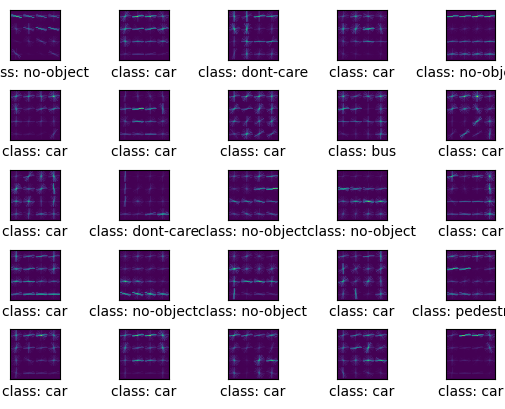

In [8]:
fig, axes = plt.subplots(5, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.8)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])

    xlabel = "class: {0}".format(categories[int(y_train[i])])
    print(xlabel)

    # Show the classes as the label on the x-axis
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])

In [10]:
image_shape = X_train[i].shape

hog_cnn_model = Sequential([
    Input(shape = image_shape),
    Conv2D(128, kernel_size=(3, 3), activation='relu'), #, padding='same'))
    Conv2D(64, kernel_size=(3, 3), activation='relu'), #, padding='same'))
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='sigmoid') # 25 classes in the dataset
])

# specify the path to save the model
checkpoints_filepath = "..\\saved-models\\best_cnn_model.hdf5"

# initialize the ModelCheckpoint callback
checkpoints = ModelCheckpoint(checkpoints_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hog_cnn_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])



model_training_time_label = 'CNN object classification training time: '

# Record the time it takes to train the model
start_time = time.time()

early_stopper = EarlyStopping(monitor = 'accuracy', min_delta = 0.001, patience = 15, verbose = 1, mode = 'auto', restore_best_weights=True)

history = hog_cnn_model.fit(X_train, y_train, 
                        batch_size = 64, 
                        epochs = 200, 
                        verbose = 1, 
                        validation_split = (0.1),
                        callbacks = [checkpoints, early_stopper])

end_time = time.time()

training_time = end_time - start_time

# Output the training time into the file
with open('..\\model-comparison-metrics', 'a') as f:
    f.write(f'{model_training_time_label}{training_time}\n')

print("Training time: {0}".format(training_time))

# Output model summary
hog_cnn_model.summary()


# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

# opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0001, decay = 1e-6)

# model = createModel(X_train.shape[1:])

# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.summary()

Epoch 1/200
807/808 [============================>.] - ETA: 0s - loss: 1.1676 - accuracy: 0.6902
Epoch 1: val_loss improved from inf to 0.67159, saving model to ..\saved-models\best_cnn_model.hdf5
808/808 [==============================] - 24s 30ms/step - loss: 1.1676 - accuracy: 0.6902 - val_loss: 0.6716 - val_accuracy: 0.8017
Epoch 2/200
806/808 [============================>.] - ETA: 0s - loss: 0.8183 - accuracy: 0.7599
Epoch 2: val_loss improved from 0.67159 to 0.58381, saving model to ..\saved-models\best_cnn_model.hdf5
808/808 [==============================] - 24s 29ms/step - loss: 0.8185 - accuracy: 0.7598 - val_loss: 0.5838 - val_accuracy: 0.8233
Epoch 3/200
807/808 [============================>.] - ETA: 0s - loss: 0.7469 - accuracy: 0.7774
Epoch 3: val_loss improved from 0.58381 to 0.53333, saving model to ..\saved-models\best_cnn_model.hdf5
808/808 [==============================] - 24s 29ms/step - loss: 0.7469 - accuracy: 0.7774 - val_loss: 0.5333 - val_accuracy: 0.8334
Ep

In [11]:
# Ouput test accuracy
score = hog_cnn_model.evaluate(X_test, y_test, verbose = 0)
print('Test Accuracy: {}'.format(score[1]))

model_path = '..\\saved-models\\object-classification-hog-cnn.pkl'  # replace with the path to your model
#dump(hog_cnn_model, model_path) # Save the model
model = load(model_path)

Test Accuracy: 0.8974493145942688


INFO:tensorflow:Assets written to: ram://87a796b7-5b8f-4be0-90c2-692b6c885bd6/assets


INFO:tensorflow:Assets written to: ram://87a796b7-5b8f-4be0-90c2-692b6c885bd6/assets


['..\\saved-models\\object-classification-hog-cnn.pkl']

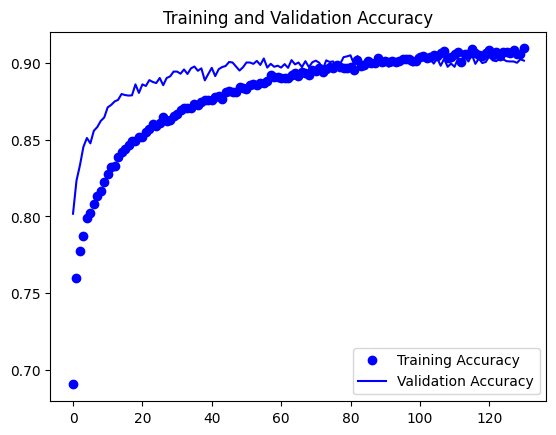

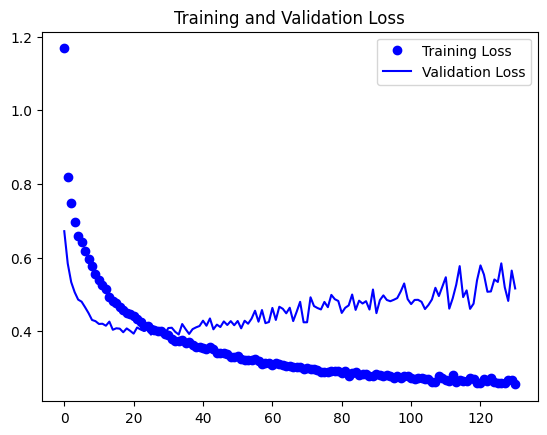

In [12]:
%matplotlib inline
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
model_prediction_time_label = 'CNN object classification prediction time: '

# Record the prediction time
start_time = time.time()

# Get the predictions for the test data
y_predicted = hog_cnn_model.predict(X_test)

# Use this for Multi-class classification
y_predicted_classes = np.argmax(y_predicted, axis=1)

# Use this for Multi-class classification
# y_predict_classes = np.argmax(y_predict, axis=1) # Try removing argmax and see what happens

# Use this for Binary classification
#predicted_classes = cnn_model.predict(X_test_gray_normalized)

# Get the indices to be plotted
y_true = y_test
correct = np.nonzero(y_predicted_classes == y_true)
incorrect = np.nonzero(y_predicted_classes != y_true)

# Mark the end time for prediction
end_time = time.time()

# Calculate prediction time
prediction_time = end_time - start_time

# Output the prediction time into the file
with open('model-comparison-metrics', 'a') as f:
    f.write(f'{model_prediction_time_label}{prediction_time}\\n')

print("Prediction time: {0}".format(prediction_time))

598/598 [==============================] - 3s 5ms/step
Prediction time: 3.968695640563965


              precision    recall  f1-score   support

           0       0.91      0.66      0.77        65
           1       0.90      0.28      0.43       100
           2       0.88      0.96      0.92      7344
           3       0.75      0.09      0.15        35
           4       0.85      0.75      0.80       439
           5       0.82      0.79      0.81      1746
           6       1.00      0.11      0.19        28
           7       0.75      0.33      0.46        18
           8       0.09      0.38      0.15        56
           9       0.89      0.68      0.77       689
          10       0.95      0.66      0.78       156
          11       0.84      0.63      0.72        73
          12       0.87      0.97      0.92      4475
          13       0.86      0.88      0.87      1808
          14       0.92      0.42      0.58       160
          15       0.38      0.75      0.51        32
          16       0.97      0.33      0.49       678
          17       1.00    

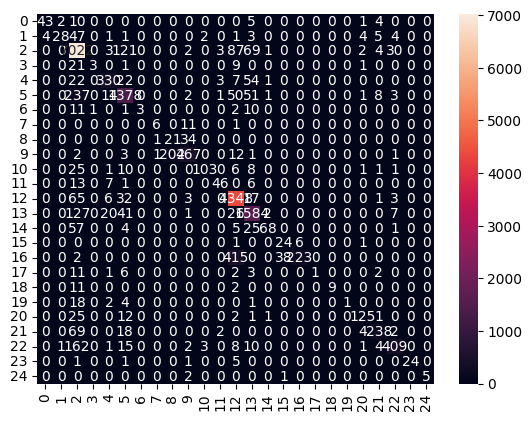

In [14]:
cm = confusion_matrix(y_test, y_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_predicted_classes))

In [15]:
scores = hog_cnn_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

598/598 [==============================] - 4s 7ms/step - loss: 0.5256 - accuracy: 0.8974
Test loss: 0.5255934596061707
Test accuracy: 0.8974493145942688


1/1 [==============================] - 0s 22ms/step


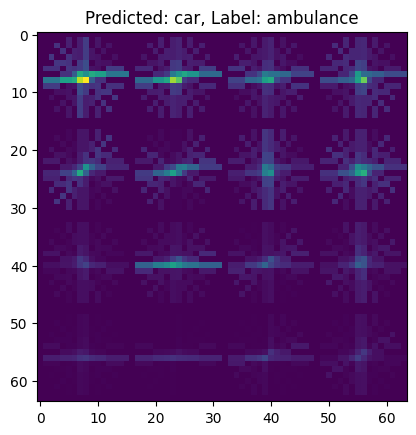

1/1 [==============================] - 0s 24ms/step


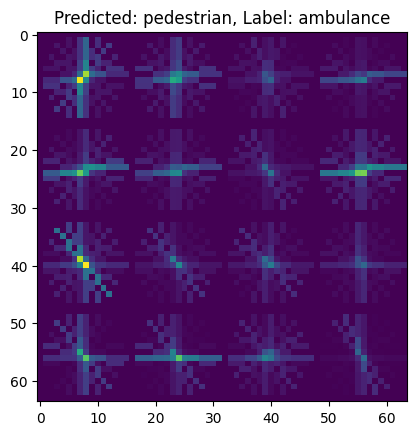

1/1 [==============================] - 0s 23ms/step


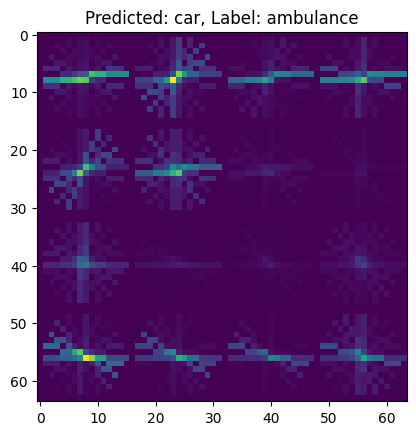

1/1 [==============================] - 0s 20ms/step


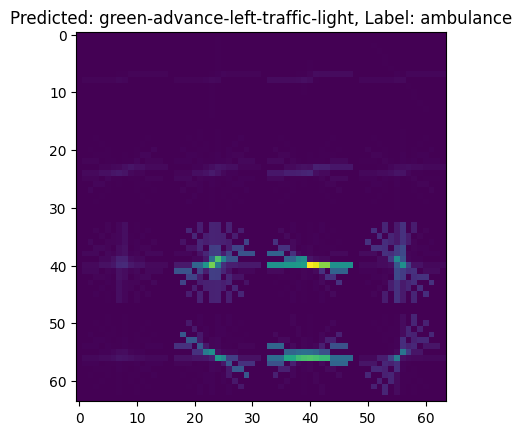

1/1 [==============================] - 0s 26ms/step


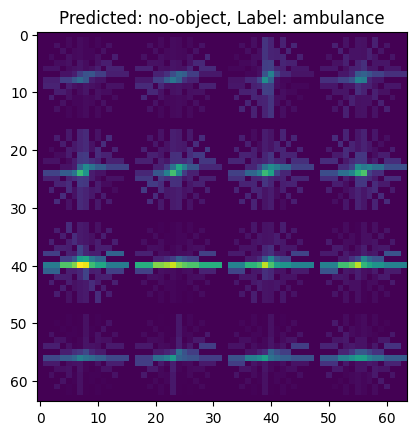

1/1 [==============================] - 0s 25ms/step


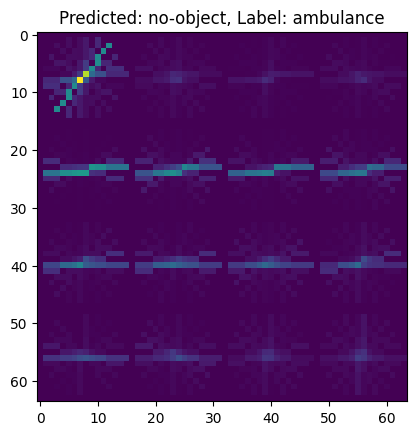

1/1 [==============================] - 0s 21ms/step


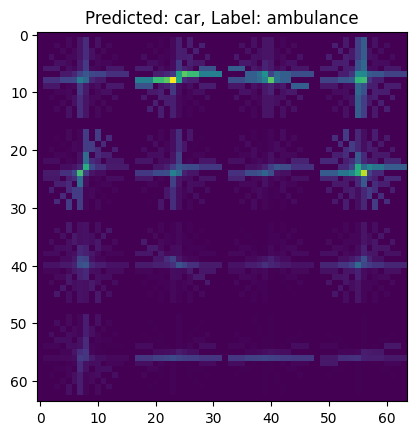

1/1 [==============================] - 0s 21ms/step


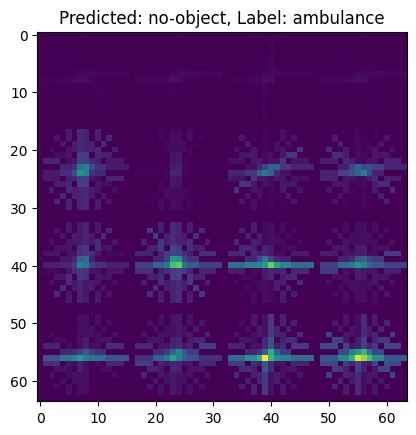

1/1 [==============================] - 0s 24ms/step


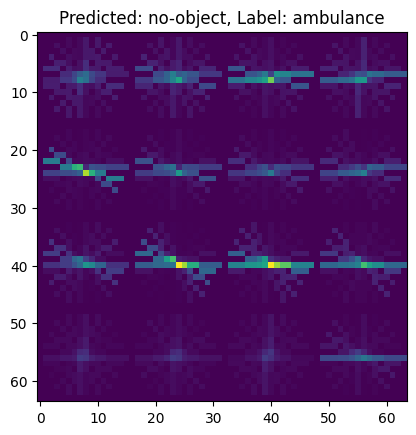

1/1 [==============================] - 0s 22ms/step


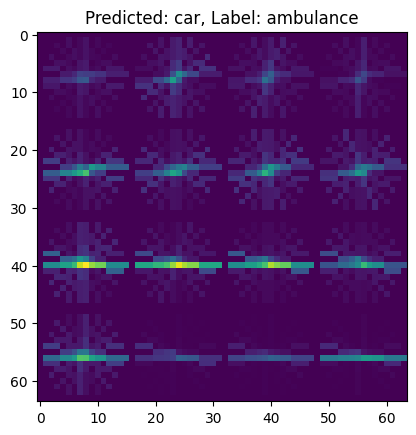

In [18]:
# Iterate over first 10 test images
for x in range(10):
    # Get test image
    test_image = X_test[x,:]
    
    # Predict class of image
    predicted_cat = hog_cnn_model.predict(np.array([test_image])).argmax()
    
    # Get actual class of image
    label = y_test[x].argmax()
    
    # If prediction is incorrect, display image with predicted and actual classes
    if (predicted_cat != label):
        plt.title(f"Predicted: {categories[predicted_cat]}, Label: {categories[label]}")
        plt.imshow(test_image)
        plt.show()

In [28]:
model_path = '..\saved-models\object-classification-hog-cnn.pkl'  # replace with path to model
#dump(hog_cnn_model, model_path) # Save the model

# save
with open(model_path,'wb') as f:
    pickle.dump(hog_cnn_model,f)

# load
with open(model_path, 'rb') as f:
    model = pickle.load(f)

#model = hog_cnn_model

UnpicklingError: invalid load key, '\x06'.

In [ ]:
test_video_path = '..\\testsets\\videos/1.mp4'
video_path_out = '{}_out.mp4'.format(video_path)

cap = cv2.VideoCapture(test_video_path)
ret, frame = cap.read()
out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame.shape[1], frame.shape[0]))


while ret:

    results = hog_cnn_model(frame)[0]
    threshold = 0.3
    for result in results.boxes.data.tolist():
        print(len(result))
        x1, y1, x2, y2, score, class_id = result

        if score > threshold:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.putText(frame, results.names[int(class_id)].upper()+(str(score)), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    out.write(frame)
    ret, frame = cap.read()

cap.release()
out.release()
cv2.destroyAllWindows()

CODE ENDS HERE

In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('path_to_your_model.h5')

# Function to preprocess frames
def preprocess_frame(frame):
    # Resize, normalize, and expand dimensions as before
    # Adjust according to your model's requirements
    frame_resized = cv2.resize(frame, (64, 64))
    frame_normalized = frame_resized / 255.0
    frame_expanded = np.expand_dims(frame_normalized, axis=0)
    return frame_expanded

# Function to draw bounding boxes and labels
def draw_bounding_boxes(frame, predictions):
    height, width, _ = frame.shape
    for pred in predictions:
        # Assuming `pred` is a tuple of (class_label, confidence, (x_min, y_min, x_max, y_max))
        class_label, confidence, bbox = pred
        x_min, y_min, x_max, y_max = bbox

        # Convert normalized coordinates back to frame size
        x_min = int(x_min * width)
        y_min = int(y_min * height)
        x_max = int(x_max * width)
        y_max = int(y_max * height)

        # Draw rectangle
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Put the label near the rectangle
        cv2.putText(frame, f'{class_label}: {confidence:.2f}', (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Capture video from the first webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    preprocessed_frame = preprocess_frame(frame)
    
    # Predict using your model
    # Make sure to adjust the prediction line to how your model outputs predictions
    predictions = model.predict(preprocessed_frame)
    
    # Translate predictions to labels and bounding boxes here
    # This will depend on your model's output format
    # For demonstration, let's assume `predictions_to_boxes` will handle this
    # predictions = predictions_to_boxes(predictions)
    
    # Draw bounding boxes and labels on the frame
    draw_bounding_boxes(frame, predictions)

    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Ali